# Setup

In [20]:
from array import array
from pathlib import Path

import confuse
import pandas

from classifier import DialogueActClassifierFactory
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dac_factory = DialogueActClassifierFactory()
dac_labels = dac_factory.get_classifier(
    Path(cfg['dialogue_act_classification']['classifier_file'].as_filename()),
    cfg['dialogue_act_classification']['test_set_percentage'].as_number()).labels()

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'program_comprehension_challenge'
report_dict_list = []

# Dialogue Act Classifier Performance

In [21]:
from collections import defaultdict

precisions, recalls = dac_factory.get_precision_and_recall()
precisions_recalls = [precisions, recalls]

dac_report = {}
dac_report[''] = [None, None, dac_factory.get_accuracy()]
for label in precisions.keys():
  dac_report[label] = [i[label] for i in precisions_recalls]

df = DataFrame.from_dict(dac_report, orient='index', columns=['Precision', 'Recall', 'Accuracy'])

df

Precision    Recall  Accuracy
                  NaN       NaN  0.666667
Statement    0.666667  0.593023       NaN
Emotion      0.989247  0.666667       NaN
System       0.951456  0.911628       NaN
Greet        1.000000  0.804878       NaN
Accept       0.615385  0.216216       NaN
Reject       0.157895  0.166667       NaN
whQuestion   0.746269  0.769231       NaN
Continuer    0.000000  0.000000       NaN
ynQuestion   0.671429  0.734375       NaN
yAnswer      0.363636  0.666667       NaN
Bye          0.739130  0.894737       NaN
Clarify      0.000000  0.000000       NaN
Emphasis     0.386364  0.500000       NaN
nAnswer      0.000000  0.000000       NaN
Other        0.000000  0.000000       NaN

# Dialogue Act Classifier Confusion Matrix

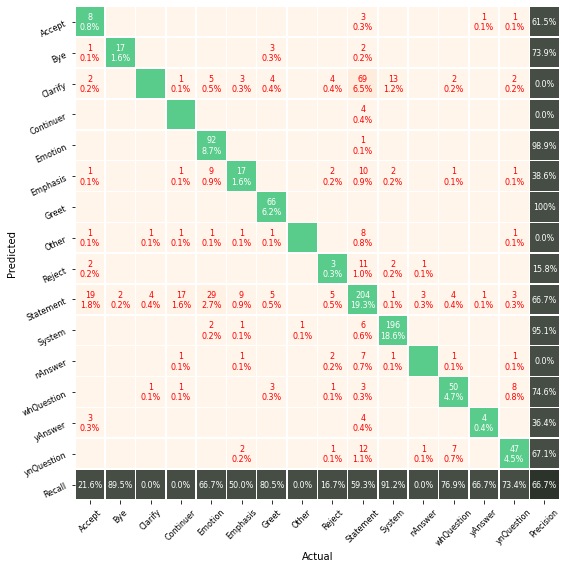

In [22]:
import seaborn
from matplotlib import pyplot

cm = dac_factory.print_confusion_matrix()

# Evenly distribute the training data labelled as "No" and "Yes".

In [23]:
X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_training_dataset = pandas.concat([labelled_yes, labelled_no])

# Shuffle the order, in order to properly train the model.
evenly_distrubted_training_dataset = evenly_distrubted_training_dataset.sample(frac=1)

X_train_evenly_dist = evenly_distrubted_training_dataset[FEATURES]
y_train_evenly_dist = evenly_distrubted_training_dataset[LABEL]

# Show the datasets value counts
dataset_dict = {}
dataset_dict['Training Dataset'] = len(training_dataset.loc[training_dataset[LABEL] == "Yes"]), len(training_dataset.loc[training_dataset[LABEL] == "No"]), len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset)
dataset_dict['Test Dataset'] = len(test_dataset.loc[test_dataset[LABEL] == "Yes"]), len(test_dataset.loc[test_dataset[LABEL] == "No"]), len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset)
df = DataFrame.from_dict(dataset_dict, orient='index', columns=['Label (Yes)', 'Label (No)', 'Ratio (Yes)'])

df

Label (Yes)  Label (No)  Ratio (Yes)
Training Dataset           92         506     0.153846
Test Dataset               39         111     0.260000

# Set up

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

is_author_categories = [
    False,  # 0 should come before 1 for numerical columns.
    True
]

# CountVectorizer - SVC

In [25]:
from sklearn.svm import SVC

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_count_vectorizer',
            CountVectorizer(stop_words='english'),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

clf_svc = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', probability=True))],
    verbose=False)

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - SVC

In [26]:
column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(stop_words='english', ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Stemming - SVC

In [27]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

column_transformer = ColumnTransformer(
    transformers=[
        ('body_count_vectorizer', StemmedCountVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SVC

In [28]:
from nlp import LemmaTokenizer

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True, ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=0.1, probability=True))
    ],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SGDClassifier

In [29]:
from sklearn.linear_model import SGDClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SGDClassifier(random_state=13))
    ],
    verbose=False)

clf_sgd = full_pipeline

clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_sgd.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - KNeighborsClassifier

In [30]:
from sklearn.neighbors import KNeighborsClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', KNeighborsClassifier())
    ],
    verbose=False)

clf_kneighbors = full_pipeline

clf_kneighbors.fit(X_train, y_train)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_kneighbors.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', BaggingClassifier(base_estimator=LogisticRegression(C=500000, solver='lbfgs'), max_samples=0.5, max_features=0.5))
    ],
    verbose=False)

clf_ensemble = full_pipeline

clf_ensemble.fit(X_train, y_train)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_ensemble.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression) (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - MultinomialNB

In [32]:
from sklearn.naive_bayes import MultinomialNB

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', MultinomialNB(fit_prior=True))],
    verbose=False)

clf_multinominal_nb = full_pipeline

clf_multinominal_nb.fit(X_train, y_train)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_multinominal_nb.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', RandomForestClassifier(max_features='auto', bootstrap=False, class_weight={'Yes': 0.2, 'No': 0.8}, random_state=20))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'Random Forest': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'Random Forest (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - LogisticRegression

In [34]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression(C=500000, solver='liblinear', multi_class='ovr', intercept_scaling=1, dual=True, penalty='l2'))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - DecisionTree

In [35]:
from sklearn.tree import DecisionTreeClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', DecisionTreeClassifier(random_state=1, min_samples_split=0.25))],
    verbose=False)

clf_decision_tree = full_pipeline

clf_decision_tree.fit(X_train, y_train)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_decision_tree.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# CodeComprehensionClassifierFactory

In [36]:
from classifier import CodeComprehensionClassifierFactory

clf_optimal = CodeComprehensionClassifierFactory.get_classifier(dac_labels)

clf_optimal.fit(X_train, y_train)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CodeComprehensionClassifierFactory': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_optimal.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CodeComprehensionClassifierFactory (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Report Performance Before Grid Search (as it is time consuming)

In [37]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

Algorithms  no_precision  \
0                               CountVectorizer - SVC      0.798450   
1          CountVectorizer - SVC (Evenly Distributed)      0.864583   
2                                         TFIDF - SVC      0.768116   
3                    TFIDF - SVC (Evenly Distributed)      0.876404   
4                              TFIDF - Stemming - SVC      0.767606   
5         TFIDF - Stemming - SVC (Evenly Distributed)      0.890411   
6                         TFIDF - Lemmatization - SVC      0.845528   
7    TFIDF - Lemmatization - SVC (Evenly Distributed)      0.897959   
8               TFIDF - Lemmatization - SGDClassifier      0.902655   
9   TFIDF - Lemmatization - SGDClassifier (Evenly ...      0.897959   
10       TFIDF - Lemmatization - KNeighborsClassifier      0.776978   
11  TFIDF - Lemmatization - KNeighborsClassifier (...      0.908046   
12  TFIDF - Lemmatization - Ensemble Classifiers (...      0.796992   
13  TFIDF - Lemmatization - Ensemble Classifiers (...      0.909091   
14              TFIDF - Lemmatization - MultinomialNB      0.740000   
15  TFIDF - Lemmatization - MultinomialNB (Evenly ...      0.883721   
16                                      Random Forest      0.786765   
17                 Random Forest (Evenly Distributed)      0.905660   
18         TFIDF - Lemmatization - LogisticRegression      0.840000   
19  TFIDF - Lemmatization - LogisticRegression (Ev...      0.895833   
20               TFIDF - Lemmatization - DecisionTree      0.928571   
21  TFIDF - Lemmatization - DecisionTree (Evenly D...      0.927835   
22                 CodeComprehensionClassifierFactory      0.846774   
23  CodeComprehensionClassifierFactory (Evenly Dis...      0.896907   

    no_recall  no_f1_score  yes_precision  yes_recall  yes_f1_score  Accuracy  
0    0.927928     0.858333       0.619048    0.333333      0.433333  0.773333  
1    0.747748     0.801932       0.481481    0.666667      0.559140  0.726667  
2    0.954955     0.851406       0.583333    0.179487      0.274510  0.753333  
3    0.702703     0.780000       0.459016    0.717949      0.560000  0.706667  
4    0.981982     0.861660       0.750000    0.153846      0.255319  0.766667  
5    0.585586     0.706522       0.402597    0.794872      0.534483  0.640000  
6    0.936937     0.888889       0.740741    0.512821      0.606061  0.826667  
7    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
8    0.918919     0.910714       0.756757    0.717949      0.736842  0.866667  
9    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
10   0.972973     0.864000       0.727273    0.205128      0.320000  0.773333  
11   0.711712     0.797980       0.492063    0.794872      0.607843  0.733333  
12   0.954955     0.868852       0.705882    0.307692      0.428571  0.786667  
13   0.810811     0.857143       0.588235    0.769231      0.666667  0.800000  
14   1.000000     0.850575       0.000000    0.000000      0.000000  0.740000  
15   0.684685     0.771574       0.453125    0.743590      0.563107  0.700000  
16   0.963964     0.866397       0.714286    0.256410      0.377358  0.780000  
17   0.864865     0.884793       0.659091    0.743590      0.698795  0.833333  
18   0.945946     0.889831       0.760000    0.487179      0.593750  0.826667  
19   0.774775     0.830918       0.537037    0.743590      0.623656  0.766667  
20   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000  
21   0.810811     0.865385       0.603774    0.820513      0.695652  0.813333  
22   0.945946     0.893617       0.769231    0.512821      0.615385  0.833333  
23   0.783784     0.836538       0.547170    0.743590      0.630435  0.773333

# Tuning the model with Grid Search

In [38]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            DecisionTreeClassifier(random_state=1, min_samples_split=0.25)
        )
    ],
    verbose=False)

yes_f1_scorer = metrics.make_scorer(metrics.f1_score, pos_label="Yes")

grid_search_cv_params = [
    {
        # {'preprocessor__body_tfidf_vectorizer__tokenizer': [None, LemmaTokenizer()]},
        # {'preprocessor__body_tfidf_vectorizer__stop_words': [None, 'english']},
        # {'preprocessor__body_tfidf_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)]},
        # 'preprocessor__transformer_weights': [
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 2},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 100},          
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 6},
        # ],
        # 'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__splitter': ['best', 'random'],
        # 'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 0.1, 0.25, 1.0],
        # 'classifier__min_samples_leaf': [1, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
        # 'classifier__min_weight_fraction_leaf': [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
        'classifier__max_features': [None, 1, 'auto', 'sqrt', 'log2'],
        'classifier__ccp_alpha': [0.0, 1.0, 100.0],
        # 'classifier__class_weight': [None, 'balanced', {'Yes': 0.175, 'No': 0.825}],
        # 'classifier__early_stopping': [True, False],
        'classifier__random_state': list(range(1, 5)),
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_f1_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 52.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 66.0min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 78.5min finished


{'classifier__ccp_alpha': 0.0,
 'classifier__criterion': 'gini',
 'classifier__max_features': None,
 'classifier__min_samples_split': 0.25,
 'classifier__random_state': 2,
 'classifier__splitter': 'best'}

In [39]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         6.892894      1.564335         0.871881        1.505053   
1         5.552301      2.817604         0.844866        1.467713   
2         3.501924      1.501228         0.839627        1.468047   
3         3.549277      1.530396         0.872149        1.529051   
4         3.637529      1.559975         0.880883        1.534788   
5         3.598246      1.543478         0.871653        1.526270   
6         3.587447      1.517820         0.844497        1.480854   
7         3.567881      1.540622         0.874185        1.531348   
8         3.652824      1.561348         0.893728        1.562953   
9         3.626908      1.550256         0.875230        1.525971   
10        3.592168      1.553430         0.853225        1.496901   
11        3.509277      1.510460         0.868000        1.519403   
12        3.725087      1.601247         0.879360        1.544184   
13        3.629900      1.566861         0.864547        1.505230   
14        3.542405      1.523615         0.893588        1.573338   
15        3.577133      1.537024         0.882612        1.544899   
16        3.691339      1.566963         0.893626        1.560250   
17        3.601940      1.557223         0.867206        1.522621   
18        3.792930      1.652258         0.977837        1.669114   
19        4.095997      1.779599         1.031972        1.781732   
20        3.981101      1.740006         1.019479        1.773652   
21        3.997911      1.743704         0.989814        1.729737   
22        3.946676      1.724485         0.889194        1.559292   
23        4.242633      1.857750         1.296846        2.174075   
24        4.837491      2.065012         1.038414        1.792367   
25        4.001205      1.756733         0.937950        1.634287   
26        3.944832      1.713820         0.976133        1.717813   
27        4.004848      1.736547         0.964174        1.667616   
28        3.925344      1.713526         0.966654        1.696645   
29        3.797133      1.650592         0.916237        1.597435   
30        3.869236      1.651472         0.931334        1.612219   
31        3.658801      1.575313         0.900360        1.572463   
32        3.604520      1.551010         0.870523        1.520330   
33        3.752988      1.569978         0.945027        1.641692   
34        3.713622      1.629703         0.915472        1.594477   
35        3.665898      1.600365         0.890486        1.559451   
36        3.665736      1.594110         0.888575        1.558719   
37        3.647165      1.571777         0.891217        1.560953   
38        3.819853      1.672564         0.996441        1.756415   
39        3.919351      1.727846         1.007829        1.787724   
40        4.218734      1.799481         0.997966        1.715547   
41        4.103683      1.787044         1.047565        1.822531   
42        3.991543      1.717803         0.979876        1.721726   
43        3.833132      1.677317         0.946703        1.656465   
44        3.878548      1.678279         0.916873        1.597014   
45        4.002561      1.724890         0.981687        1.724844   
46        3.876135      1.684223         0.936362        1.653320   
47        4.411738      1.994321         1.211888        2.136284   
48        4.259260      1.878348         0.939851        1.652751   
49        3.919189      1.703547         1.049940        1.820890   
50        3.969450      1.734192         0.903474        1.583380   
51        3.729882      1.613915         0.894265        1.568818   
52        3.692732      1.587951         0.899246        1.574356   
53        3.689819      1.578648         0.897392        1.569554   
54        3.607829      1.564202         0.883488        1.555759   
55        3.578409      1.554623         0.927894        1.628124   
56        3.660303      1.596416         0.909168        1.597422   
57 

In [40]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Performance Result Comparison

In [41]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

Algorithms  no_precision  \
0                               CountVectorizer - SVC      0.798450   
1          CountVectorizer - SVC (Evenly Distributed)      0.864583   
2                                         TFIDF - SVC      0.768116   
3                    TFIDF - SVC (Evenly Distributed)      0.876404   
4                              TFIDF - Stemming - SVC      0.767606   
5         TFIDF - Stemming - SVC (Evenly Distributed)      0.890411   
6                         TFIDF - Lemmatization - SVC      0.845528   
7    TFIDF - Lemmatization - SVC (Evenly Distributed)      0.897959   
8               TFIDF - Lemmatization - SGDClassifier      0.902655   
9   TFIDF - Lemmatization - SGDClassifier (Evenly ...      0.897959   
10       TFIDF - Lemmatization - KNeighborsClassifier      0.776978   
11  TFIDF - Lemmatization - KNeighborsClassifier (...      0.908046   
12  TFIDF - Lemmatization - Ensemble Classifiers (...      0.796992   
13  TFIDF - Lemmatization - Ensemble Classifiers (...      0.909091   
14              TFIDF - Lemmatization - MultinomialNB      0.740000   
15  TFIDF - Lemmatization - MultinomialNB (Evenly ...      0.883721   
16                                      Random Forest      0.786765   
17                 Random Forest (Evenly Distributed)      0.905660   
18         TFIDF - Lemmatization - LogisticRegression      0.840000   
19  TFIDF - Lemmatization - LogisticRegression (Ev...      0.895833   
20               TFIDF - Lemmatization - DecisionTree      0.928571   
21  TFIDF - Lemmatization - DecisionTree (Evenly D...      0.927835   
22                 CodeComprehensionClassifierFactory      0.846774   
23  CodeComprehensionClassifierFactory (Evenly Dis...      0.896907   
24                                         GridSearch      0.928571   

    no_recall  no_f1_score  yes_precision  yes_recall  yes_f1_score  Accuracy  
0    0.927928     0.858333       0.619048    0.333333      0.433333  0.773333  
1    0.747748     0.801932       0.481481    0.666667      0.559140  0.726667  
2    0.954955     0.851406       0.583333    0.179487      0.274510  0.753333  
3    0.702703     0.780000       0.459016    0.717949      0.560000  0.706667  
4    0.981982     0.861660       0.750000    0.153846      0.255319  0.766667  
5    0.585586     0.706522       0.402597    0.794872      0.534483  0.640000  
6    0.936937     0.888889       0.740741    0.512821      0.606061  0.826667  
7    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
8    0.918919     0.910714       0.756757    0.717949      0.736842  0.866667  
9    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
10   0.972973     0.864000       0.727273    0.205128      0.320000  0.773333  
11   0.711712     0.797980       0.492063    0.794872      0.607843  0.733333  
12   0.954955     0.868852       0.705882    0.307692      0.428571  0.786667  
13   0.810811     0.857143       0.588235    0.769231      0.666667  0.800000  
14   1.000000     0.850575       0.000000    0.000000      0.000000  0.740000  
15   0.684685     0.771574       0.453125    0.743590      0.563107  0.700000  
16   0.963964     0.866397       0.714286    0.256410      0.377358  0.780000  
17   0.864865     0.884793       0.659091    0.743590      0.698795  0.833333  
18   0.945946     0.889831       0.760000    0.487179      0.593750  0.826667  
19   0.774775     0.830918       0.537037    0.743590      0.623656  0.766667  
20   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000  
21   0.810811     0.865385       0.603774    0.820513      0.695652  0.813333  
22   0.945946     0.893617       0.769231    0.512821      0.615385  0.833333  
23   0.783784     0.836538       0.547170    0.743590      0.630435  0.773333  
24   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000

# GridSearch with Evenly Distributed Dataset

In [42]:
clf_grid_search_cv.fit(X_train_evenly_dist, y_train_evenly_dist)
clf_grid_search_cv.best_params_


Fitting 5 folds for each of 960 candidates, totalling 4800 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  4.8min finished


{'classifier__ccp_alpha': 0.0,
 'classifier__criterion': 'gini',
 'classifier__max_features': None,
 'classifier__min_samples_split': 1.0,
 'classifier__random_state': 1,
 'classifier__splitter': 'best'}

In [43]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.372933      0.012938         0.059487        0.003822   
1         0.307536      0.040276         0.052710        0.007791   
2         0.259144      0.005431         0.051333        0.006585   
3         0.257454      0.015053         0.054477        0.007300   
4         0.264122      0.017501         0.054481        0.008376   
5         0.284313      0.011170         0.057881        0.004824   
6         0.277525      0.007302         0.053065        0.005675   
7         0.267422      0.005141         0.052251        0.006650   
8         0.263028      0.008368         0.050044        0.009125   
9         0.281117      0.017801         0.051229        0.007657   
10        0.281662      0.011533         0.044380        0.006256   
11        0.233314      0.022118         0.047786        0.009570   
12        0.223224      0.010563         0.041040        0.005131   
13        0.212298      0.005728         0.042794        0.007201   
14        0.207018      0.008246         0.046012        0.003404   
15        0.214712      0.009807         0.043055        0.004341   
16        0.221737      0.006741         0.045014        0.004975   
17        0.227709      0.009173         0.049128        0.006913   
18        0.235330      0.007385         0.047929        0.007405   
19        0.240760      0.006806         0.047592        0.002057   
20        0.242659      0.007327         0.049123        0.003506   
21        0.239218      0.010105         0.048013        0.002769   
22        0.237017      0.007744         0.046767        0.006384   
23        0.235541      0.003871         0.045881        0.004260   
24        0.273245      0.024366         0.049983        0.004057   
25        0.261408      0.036746         0.046533        0.005407   
26        0.220842      0.006067         0.049353        0.010503   
27        0.234536      0.021678         0.050247        0.016268   
28        0.224158      0.006375         0.044776        0.004926   
29        0.212710      0.008013         0.043490        0.005209   
30        0.216188      0.005080         0.043822        0.004217   
31        0.212081      0.008877         0.044474        0.003863   
32        0.210589      0.003899         0.045386        0.006300   
33        0.214319      0.009958         0.044008        0.004910   
34        0.211954      0.009352         0.043476        0.004681   
35        0.221163      0.004223         0.043442        0.003760   
36        0.220545      0.007404         0.043026        0.004680   
37        0.223141      0.004466         0.047890        0.006082   
38        0.242601      0.021958         0.064857        0.021013   
39        0.226556      0.011853         0.045938        0.006162   
40        0.263113      0.010125         0.054130        0.006557   
41        0.231778      0.006461         0.053515        0.012413   
42        0.257353      0.007441         0.047865        0.005452   
43        0.221211      0.015462         0.042993        0.005077   
44        0.217537      0.010073         0.043928        0.005107   
45        0.235957      0.007338         0.045314        0.005617   
46        0.219520      0.014431         0.042903        0.005034   
47        0.214456      0.006830         0.044964        0.006137   
48        0.226871      0.005538         0.050346        0.006052   
49        0.225217      0.014780         0.044404        0.005435   
50        0.211255      0.006269         0.043346        0.005446   
51        0.219879      0.007267         0.043670        0.004226   
52        0.224284      0.012516         0.046009        0.005417   
53        0.226719      0.007510         0.046719        0.006860   
54        0.230331      0.003903         0.048028        0.004203   
55        0.223592      0.006866         0.043797        0.005656   
56        0.212214      0.003548         0.045899        0.003204   
57 

In [44]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Performance Result Comparison

In [45]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

Algorithms  no_precision  \
0                               CountVectorizer - SVC      0.798450   
1          CountVectorizer - SVC (Evenly Distributed)      0.864583   
2                                         TFIDF - SVC      0.768116   
3                    TFIDF - SVC (Evenly Distributed)      0.876404   
4                              TFIDF - Stemming - SVC      0.767606   
5         TFIDF - Stemming - SVC (Evenly Distributed)      0.890411   
6                         TFIDF - Lemmatization - SVC      0.845528   
7    TFIDF - Lemmatization - SVC (Evenly Distributed)      0.897959   
8               TFIDF - Lemmatization - SGDClassifier      0.902655   
9   TFIDF - Lemmatization - SGDClassifier (Evenly ...      0.897959   
10       TFIDF - Lemmatization - KNeighborsClassifier      0.776978   
11  TFIDF - Lemmatization - KNeighborsClassifier (...      0.908046   
12  TFIDF - Lemmatization - Ensemble Classifiers (...      0.796992   
13  TFIDF - Lemmatization - Ensemble Classifiers (...      0.909091   
14              TFIDF - Lemmatization - MultinomialNB      0.740000   
15  TFIDF - Lemmatization - MultinomialNB (Evenly ...      0.883721   
16                                      Random Forest      0.786765   
17                 Random Forest (Evenly Distributed)      0.905660   
18         TFIDF - Lemmatization - LogisticRegression      0.840000   
19  TFIDF - Lemmatization - LogisticRegression (Ev...      0.895833   
20               TFIDF - Lemmatization - DecisionTree      0.928571   
21  TFIDF - Lemmatization - DecisionTree (Evenly D...      0.927835   
22                 CodeComprehensionClassifierFactory      0.846774   
23  CodeComprehensionClassifierFactory (Evenly Dis...      0.896907   
24                                         GridSearch      0.928571   
25                    GridSearch (Evenly Distributed)      0.928571   

    no_recall  no_f1_score  yes_precision  yes_recall  yes_f1_score  Accuracy  
0    0.927928     0.858333       0.619048    0.333333      0.433333  0.773333  
1    0.747748     0.801932       0.481481    0.666667      0.559140  0.726667  
2    0.954955     0.851406       0.583333    0.179487      0.274510  0.753333  
3    0.702703     0.780000       0.459016    0.717949      0.560000  0.706667  
4    0.981982     0.861660       0.750000    0.153846      0.255319  0.766667  
5    0.585586     0.706522       0.402597    0.794872      0.534483  0.640000  
6    0.936937     0.888889       0.740741    0.512821      0.606061  0.826667  
7    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
8    0.918919     0.910714       0.756757    0.717949      0.736842  0.866667  
9    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
10   0.972973     0.864000       0.727273    0.205128      0.320000  0.773333  
11   0.711712     0.797980       0.492063    0.794872      0.607843  0.733333  
12   0.954955     0.868852       0.705882    0.307692      0.428571  0.786667  
13   0.810811     0.857143       0.588235    0.769231      0.666667  0.800000  
14   1.000000     0.850575       0.000000    0.000000      0.000000  0.740000  
15   0.684685     0.771574       0.453125    0.743590      0.563107  0.700000  
16   0.963964     0.866397       0.714286    0.256410      0.377358  0.780000  
17   0.864865     0.884793       0.659091    0.743590      0.698795  0.833333  
18   0.945946     0.889831       0.760000    0.487179      0.593750  0.826667  
19   0.774775     0.830918       0.537037    0.743590      0.623656  0.766667  
20   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000  
21   0.810811     0.865385       0.603774    0.820513      0.695652  0.813333  
22   0.945946     0.893617       0.769231    0.512821      0.615385  0.833333  
23   0.783784     0.836538       0.547170    0.743590      0.630435  0.773333  
24   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000  
25   0.819820     0.870813       0.615385    

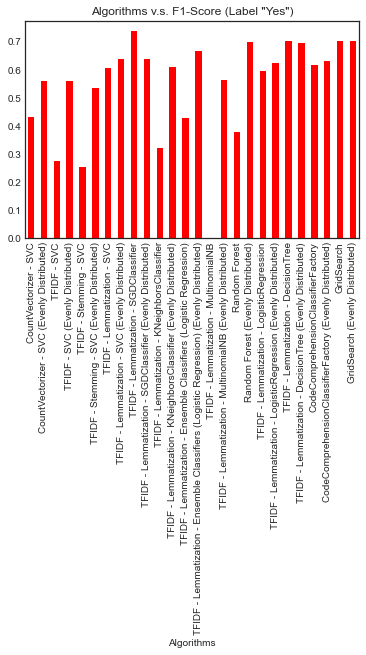

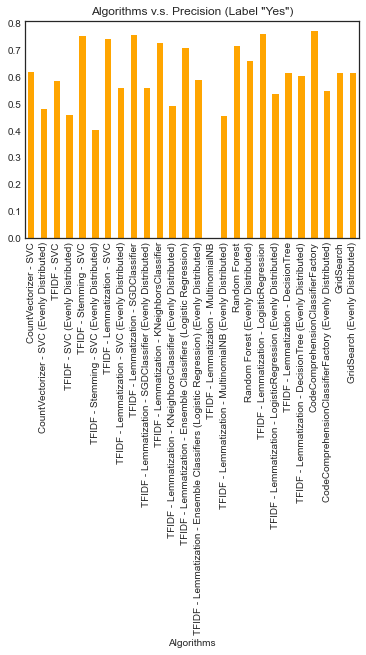

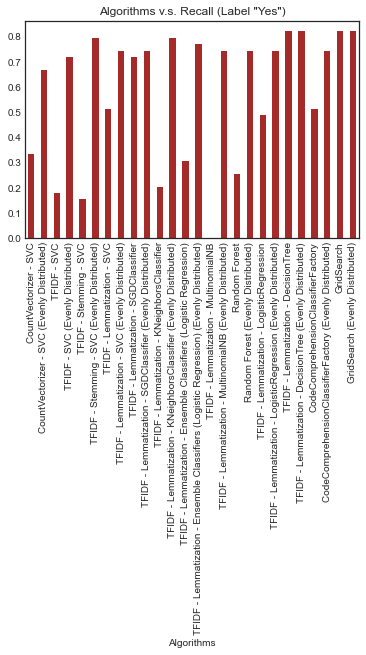

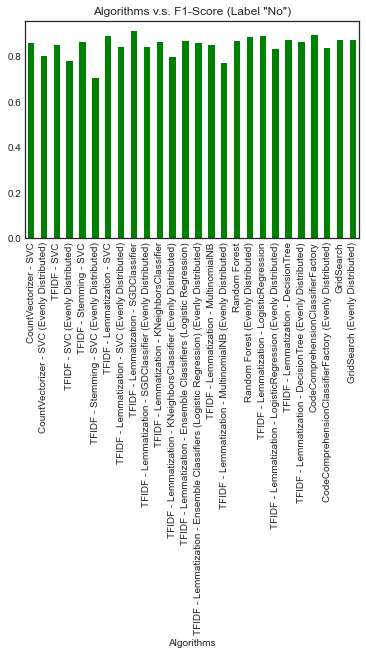

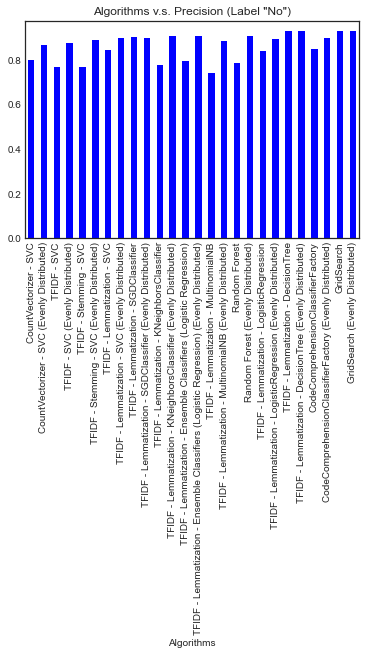

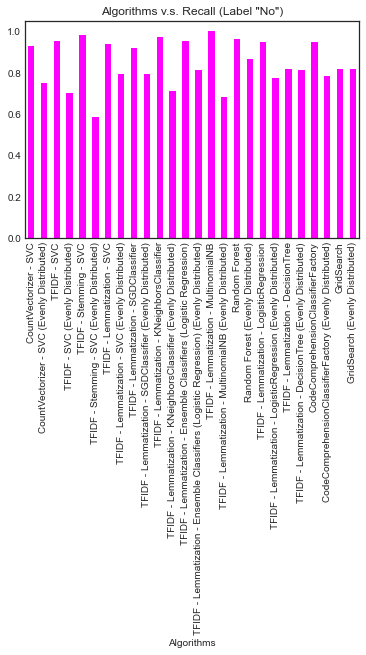

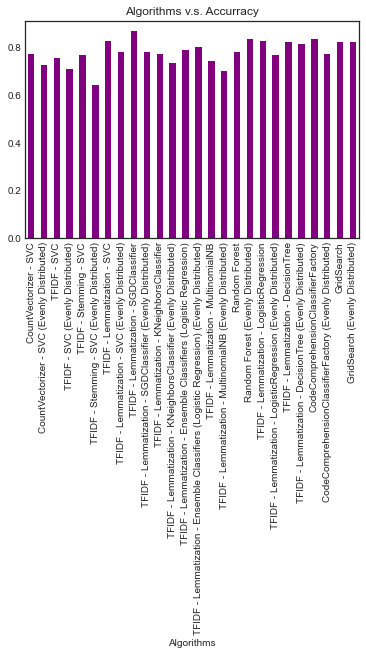

In [46]:
from matplotlib import pyplot

with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='brown', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)

# Save the trained Model

In [53]:
from joblib import dump
dump(clf_grid_search_cv, './models/program_comprehension_challenge_gridsearchcv.pickle')


['./models/program_comprehension_challenge_gridsearchcv.pickle']